In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import sys
sys.path.append("../scripts/")
from clean_data import DataCleaner
from utils import Utils
from HypothesisPlot import HypothesisPlot 
from DistributionPlots import DistributionPlots 
from PlottingFunctions import PlottingFunctions 

import warnings
warnings.filterwarnings('ignore')

In [2]:
cleaner = DataCleaner()
util=Utils()
dp=DistributionPlots()
hp=HypothesisPlot()
pl=PlottingFunctions()


In [3]:
df = util.load_data('../data/AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


### Classical A/B Testing

In [4]:
responsive_users= cleaner.drop_unresponsive(df)
responsive_users.groupby('experiment').agg({'auction_id':'count','yes':'sum','no':'sum'})


,auction_id,yes,no
experiment,,,
control,586,264,322
exposed,657,308,349


In [5]:
responsive_users 

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1
...,...,...,...,...,...,...,...,...,...
8059,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1,0
8063,ffb176df-ecd2-45d3-b05f-05b173a093a7,exposed,2020-07-04,1,Generic Smartphone,6,Chrome Mobile,1,0
8064,ffb79718-6f25-4896-b6b3-e58b80a6e147,control,2020-07-09,7,Generic Smartphone,6,Chrome Mobile,0,1
8069,ffca1153-c182-4f32-9e90-2a6008417497,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0,1


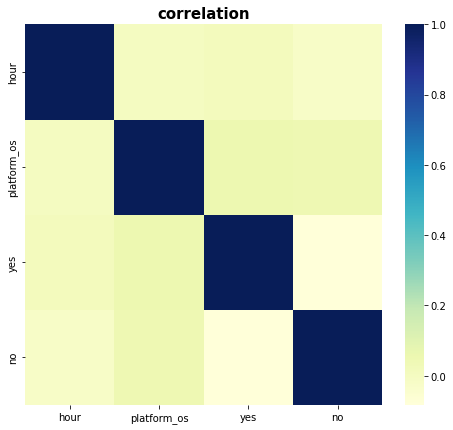

In [6]:
# Correlation Analysis

plt.figure(figsize=(8, 7))
corr = df.corr()
sns.heatmap(corr,cmap="YlGnBu")
plt.title('correlation', fontsize=15, fontweight='bold')
plt.show()

In [7]:
ab_summary = responsive_users.pivot_table(values='yes', index='experiment', aggfunc=np.sum)
ab_summary['total'] = responsive_users.pivot_table(values='yes', index='experiment', aggfunc=lambda x: len(x))
ab_summary['no']=ab_summary['total']-ab_summary['yes']
ab_summary['baseline rate'] = responsive_users.pivot_table(values='yes', index='experiment') # sums all the yes values(counts yes values) and divide to the total so it gives us the yes percentage
ab_summary=ab_summary[['yes','no','total','baseline rate']]
ab_summary

,yes,no,total,baseline rate
experiment,,,,
control,264,322,586,0.450512
exposed,308,349,657,0.468798


In [8]:
cr_exposed=ab_summary.loc['exposed','baseline rate']
cr_control=ab_summary.loc['control','baseline rate']
print(f"the conversion rate between control and exposed group is {cr_exposed-cr_control}")

the conversion rate between control and exposed group is 0.018285619295484168


### visualization of aware groups

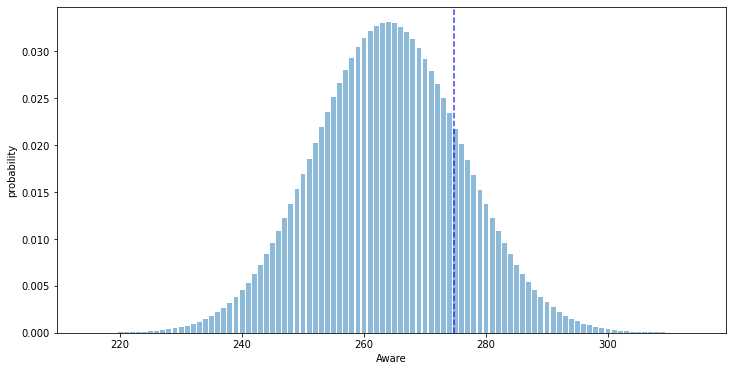

In [9]:
c_aware=ab_summary['yes']['control']
c_total=ab_summary['total']['control']
e_aware=ab_summary['yes']['exposed']
e_total=ab_summary['total']['exposed']
c_cr,e_cr= ab_summary['baseline rate']
dp.cont_distribution(c_aware,c_total,c_cr,e_cr)

### visualization of the two groups

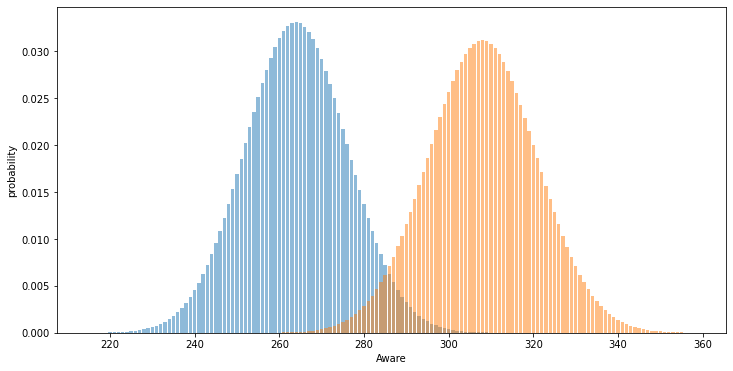

In [10]:
dp.cont_exp_distribution(c_aware,e_aware,c_total,e_total,c_cr,e_cr)

we can see that the controlled group converted more than the exposed group

### Standard Error of Mean

> `SE (control) = √((control baseline rate * (1 - control baseline rate)) / total control )` <br>
> `SE (exposed)= √((exposed baseline rate * (1 - exposed baseline rate)) / total exposed )`

In [11]:
se_control = np.sqrt((c_cr * (1 - c_cr)) / c_total)
se_exposed = np.sqrt((e_cr * (1 - e_cr)) / e_total)

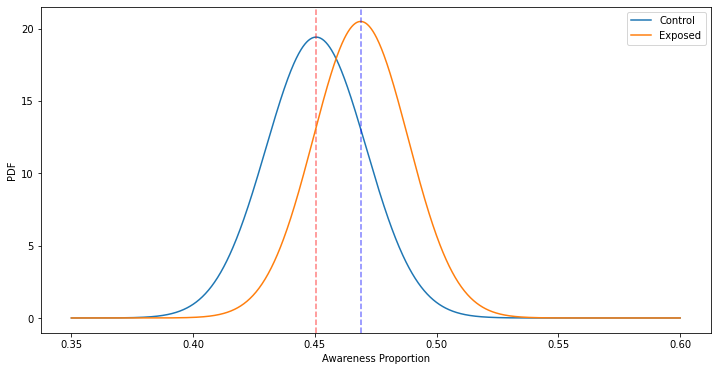

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(c_cr, se_control).pdf(x)
ax.plot(x, yC, label='Control')
ax.axvline(x=c_cr, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(e_cr, se_exposed).pdf(x)
ax.plot(x, yE, label='Exposed')
ax.axvline(x=e_cr, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Awareness Proportion')
plt.ylabel('PDF')
plt.show()

we can see the mean conversion rates from each group represented by the vertical broken lines

Variance of the sum

A basic property of variance is that the variance of the sum of two random independent variables is the sum of the variances.
This means that the null hypothesis and alternative hypothesis will have the same variance, which will be, the sum of the variances for the control group and the test group.

In [13]:
#calculate variance of sum
se_control,se_exposed

(0.02055339057798332, 0.019468837373132736)

Null hypothesis Vs. Alternative hypothesis

Null hypothesis(H0) suggests that there is no difference in brand awareness between conrolled and exposed group
Alternative hypothesis(H1) suggests a difference in brand awarness

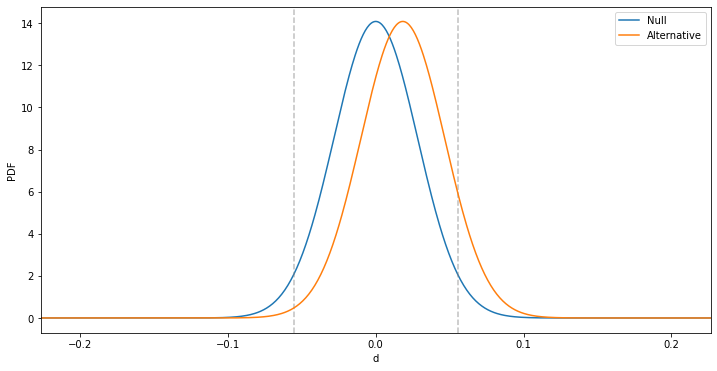

In [14]:
diff = e_cr - c_cr
hp.hypo_plot(c_total, e_total, c_cr, diff)

the H1 curve suggests exposed group has higher conversion rate than controlled group

### Z-score & p-value

In [15]:

z_score = (diff) / np.sqrt(se_control**2 + se_exposed**2)
print(f"zscore is {z_score:0.5f}, with p-value {scs.norm().sf(z_score):0.5f}")

zscore is 0.64590, with p-value 0.25917


p-value helps us determine how likely it is to get a particular result when the null hypothesis is assumed to be true.
if the null hypothesis is assuemed to be true, the p-value gives us an estimate of how strange our sample is
if the p-value is very small(<0.05) then we are likely to reject the null hypothesis.

But in our case the p-value is 0.259 greater than 0.05(significance level).

Thus, we can't reject the null hypothesis

### Statistical power

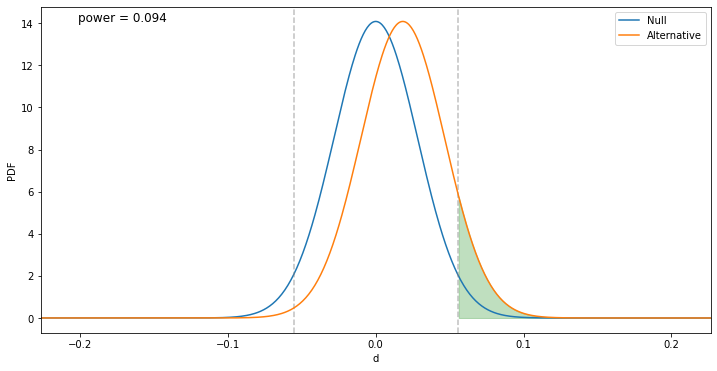

In [16]:
hp.hypo_plot(c_total, e_total, c_cr, diff,show_power=True)


Statistical power is calculated by finding the area under the alternative hypothesis distribution and outisde of the confidence interval of the null hypothesis

### Statistical Power And Significance level

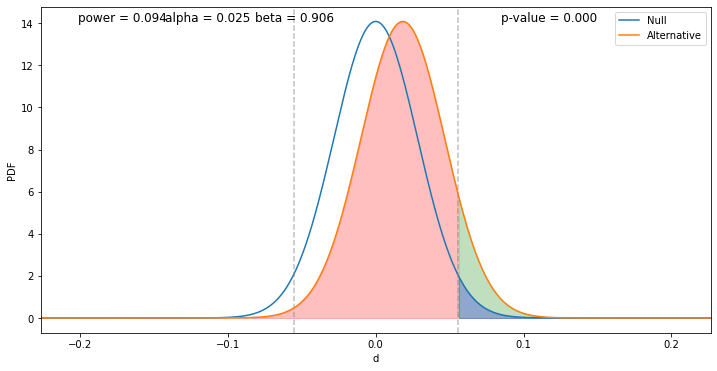

In [17]:
hp.hypo_plot(c_total,e_total,c_cr,diff,show_power=True, show_beta=True, show_alpha=True, show_p_value=True)

- The H0 which is  is the red.
- The alternate hypothesis is the blue one.
- The gray dashed lines are confidence interval at 95% (0.05).
- we get a small value for power wwhich is 9.4%
- The H1 which is  indicates the chance of us making a typeII error is 90.6%.
- Thus, we need to gather more data to make a sound conclusion

### Confidence level

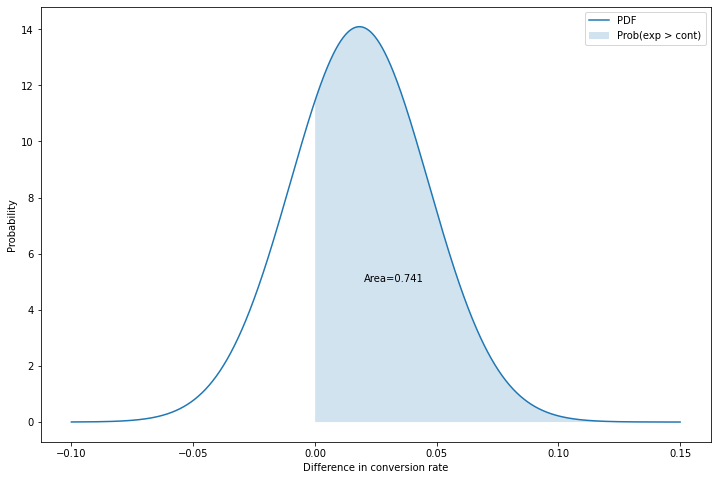

In [21]:
p = scs.norm(diff, np.sqrt(se_control**2 + se_exposed**2))
x = np.linspace(-0.1, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.subplots(figsize=(12, 8))
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x > 0, label="Prob(exp > cont)", alpha=0.2)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate")
plt.ylabel("Probability")
plt.show()

- A confidence interval displays the probability that a parameter will fall between a pair of values around the mean
- Our confidence interval is 0.741
- It means the exposed group have 74.1% awarness as the controlled one
- For the remaining percent the exposed group have different awareness from the controlled group

Optimal sample size

How much more data do we need to get the power to 80%?

In [18]:
def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    standard_norm = scs.norm(0, 1)
    Z_beta = standard_norm.ppf(power)
    Z_alpha = standard_norm.ppf(1-sig_level/2)
    pooled_prob = (bcr + bcr+mde) / 2
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2/ mde**2)
    return min_N

In [20]:
power = 0.8
sig_level = 0.05
sample_80 = round(min_sample_size(c_cr, diff, power,  sig_level))
print(f'Minimum sample size for 80% statistical power is : {sample_80} ')

Minimum sample size for 80% statistical power is : 11661 


How much more data do we need to get the power to 90%?

In [22]:
power = 0.9
sig_level = 0.05
sample_80 = round(min_sample_size(c_cr, diff, power,  sig_level))
print(f'Minimum sample size for statistical 90% power is : {sample_80} ')

Minimum sample size for statistical 90% power is : 15610 


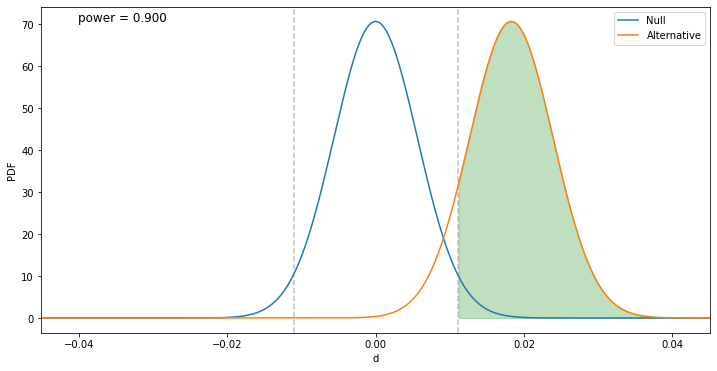

In [23]:
hp.hypo_plot(sample_80, sample_80, c_cr, diff, show_power=True)

In [25]:

power = 0.8
sig_level = 0.1
sample_80 = round(min_sample_size(c_cr, diff, power,  sig_level))
print(f'Minimum sample size for 80% statistical power is : {sample_80} ')

Minimum sample size for 80% statistical power is : 9185 
